# MLP

In [ ]:
# machine learning module
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# ANN module
import torch
from torch import nn, optim                           # torch 에서 제공하는 신경망 기술, 손실함수, 최적화를 할 수 있는 함수들을 불러온다.
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.

# Loss
from sklearn.metrics import mean_squared_error        # regression 문제의 모델 성능 측정을 위해서 MSE를 불러온다.

import matplotlib.pyplot as plt

In [2]:
# Load datset
bos = load_boston()

df = pd.DataFrame(bos.data)       # bos.data: 데이터 불러오기
df.columns = bos.feature_names    # bos.feature_names: 컬럼명 불러오기
df['Price'] = bos.target          # bos.target: 타겟값 불러오기

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [3]:
# Data Processing

# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기

# 데이터 스케일링
# sklearn에서 제공하는 MinMaxScaler 
# (X-min(X))/(max(X)-min(X))을 계산
scaler = MinMaxScaler() 
scaler.fit(X) 
X = scaler.transform(X)

scaler.fit(Y)
Y = scaler.transform(Y)

In [4]:
# 텐서 데이터와 배치 생성

# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [5]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# 기준으로 잡은 논문이 전체 데이터를 50%, 50%로 나눴기 때문에 test size를 0.5로 설정한다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [6]:
# 모델 구축

class MLP(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x
    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [7]:
# 모델, 손실함수, 최적화 방법을 선언
# lr은 학습률, weight_decay는 L2 norm 정규화에서 사용하는 penalty를 나타내는 하이퍼파라미터


model = MLP()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [8]:
# 학습

loss_ = [] # loss를 저장할 리스트.
n = len(trainloader)

for epoch in range(400):

  running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
    
    inputs, values = data # data에는 X, Y가 들어있다.

    optimizer.zero_grad() # 최적화 초기화.

    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
  
  loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

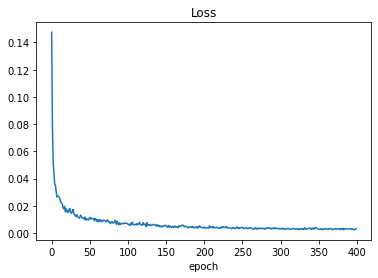

In [9]:
# loss

plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [10]:
# 모델 평가

def evaluation(dataloader):

  predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

  with torch.no_grad():
    model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다. 

    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
      actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

  predictions = predictions.numpy() # 넘파이 배열로 변경.
  actual = actual.numpy() # 넘파이 배열로 변경.
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.

  return rmse

# 평가를 할 때는 gradient를 구하고 최적화를 하지는 않으니 torch.no_grad() 안에다 식을 넣어본다. 
# 이 의미는 gradient를 없애고 계산하겠다는 의미이다. 그러면 gradient에 대한 메모리를 따로 저장할 필요가 없다.
# eval을 하면 우리가 학습시에 dropout을 사용했는데, 평가할 때는 노드를 없애면 안되니까 당연히 dropout을 사용하지 않게 한다.

In [11]:
train_rmse = evaluation(trainloader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다. 
test_rmse = evaluation(testloader)

print(f'train rmse:{train_rmse}')
print(f'test rmse:{test_rmse}')

train rmse:0.03962415084242821
test rmse:0.07404744625091553


# DNN

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

In [2]:
# Image Transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
# train(학습용) 데이터셋 로드
train_data = datasets.FashionMNIST(root='data', 
                                   train=True,        # 학습용 데이터셋 설정(True)
                                   download=True, 
                                   transform=transform                
                                  )

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# test(학습용) 데이터셋 로드
test_data = datasets.FashionMNIST(root='data', 
                                  train=False,        # 검증용 데이터셋 설정(False)
                                  download=True, 
                                  transform=transform
                                 )


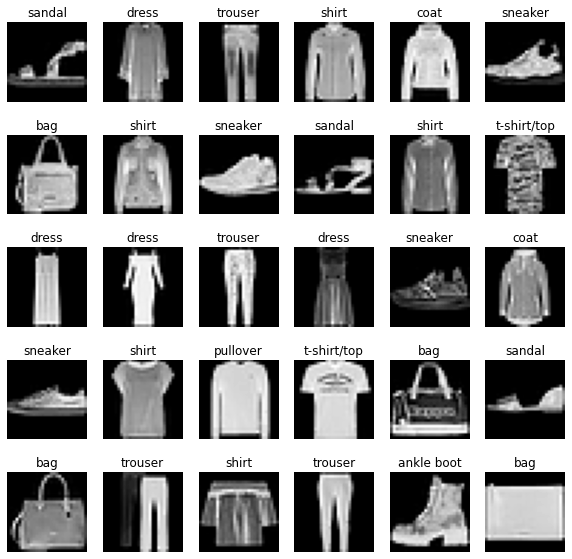

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    #plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
    plt.imshow(to_pil_image(img), cmap='gray') # 텐서 문제로 tensor를 pil image로 변경
plt.show()

In [12]:
batch_size = 32 # batch_size 지정
num_workers = 8 # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

In [13]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=num_workers)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          shuffle=False, 
                                          num_workers=num_workers)

In [15]:
# 1개의 배치 추출 후 Image, label의 shape 출력
img, lbl = next(iter(train_loader))
img.shape, lbl.shape
#(torch.Size([32, 1, 28, 28]), torch.Size([32])) 
# 배치사이즈인 32가 가장 첫번째 dimension에 출력되고, 그 뒤로 채널, 세로, 가로 순서로 출력이 됩니다.
# 즉, greyscale 의 28 X 28 이미지 32장이 1개의 배치로 구성이 되어 있습니다.

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### 모델 정의

In [16]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x     

In [18]:
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

DNNModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

In [19]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

### 모델 훈련

In [20]:
from tqdm import tqdm  # Progress Bar 출력

In [21]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

### 모델 평가

In [22]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

### 모델 훈련 & 검증

In [23]:
# 최대 Epoch을 지정합니다.
num_epochs = 20

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 1875/1875 [00:24<00:00, 77.09it/s]


[INFO] val_loss has been improved from inf to 0.46064. Saving Model!
epoch 01, loss: 0.55006, acc: 0.80053, val_loss: 0.46064, val_accuracy: 0.83490


100%|██████████| 1875/1875 [00:23<00:00, 79.59it/s]


[INFO] val_loss has been improved from 0.46064 to 0.37798. Saving Model!
epoch 02, loss: 0.37395, acc: 0.86260, val_loss: 0.37798, val_accuracy: 0.86300


100%|██████████| 1875/1875 [00:23<00:00, 79.91it/s]


[INFO] val_loss has been improved from 0.37798 to 0.35950. Saving Model!
epoch 03, loss: 0.33231, acc: 0.87848, val_loss: 0.35950, val_accuracy: 0.86840


100%|██████████| 1875/1875 [00:23<00:00, 79.95it/s]


epoch 04, loss: 0.30725, acc: 0.88655, val_loss: 0.36688, val_accuracy: 0.87030


100%|██████████| 1875/1875 [00:23<00:00, 79.39it/s]


epoch 05, loss: 0.28642, acc: 0.89327, val_loss: 0.37663, val_accuracy: 0.86840


100%|██████████| 1875/1875 [00:23<00:00, 78.59it/s]


[INFO] val_loss has been improved from 0.35950 to 0.35047. Saving Model!
epoch 06, loss: 0.27372, acc: 0.89828, val_loss: 0.35047, val_accuracy: 0.87700


100%|██████████| 1875/1875 [00:23<00:00, 78.98it/s]


[INFO] val_loss has been improved from 0.35047 to 0.32763. Saving Model!
epoch 07, loss: 0.25921, acc: 0.90415, val_loss: 0.32763, val_accuracy: 0.88460


100%|██████████| 1875/1875 [00:23<00:00, 78.88it/s]


epoch 08, loss: 0.24667, acc: 0.90675, val_loss: 0.33244, val_accuracy: 0.88220


100%|██████████| 1875/1875 [00:23<00:00, 78.23it/s]


epoch 09, loss: 0.23445, acc: 0.91227, val_loss: 0.33829, val_accuracy: 0.88450


100%|██████████| 1875/1875 [00:27<00:00, 68.68it/s]


epoch 10, loss: 0.22575, acc: 0.91547, val_loss: 0.34730, val_accuracy: 0.88240


100%|██████████| 1875/1875 [00:24<00:00, 77.28it/s]


epoch 11, loss: 0.21653, acc: 0.91692, val_loss: 0.37442, val_accuracy: 0.87670


100%|██████████| 1875/1875 [00:25<00:00, 74.69it/s]


epoch 12, loss: 0.20732, acc: 0.92170, val_loss: 0.35105, val_accuracy: 0.88340


100%|██████████| 1875/1875 [00:24<00:00, 76.52it/s]


epoch 13, loss: 0.20277, acc: 0.92422, val_loss: 0.33801, val_accuracy: 0.88780


100%|██████████| 1875/1875 [00:24<00:00, 77.24it/s]


[INFO] val_loss has been improved from 0.32763 to 0.32482. Saving Model!
epoch 14, loss: 0.19276, acc: 0.92785, val_loss: 0.32482, val_accuracy: 0.89010


100%|██████████| 1875/1875 [00:23<00:00, 78.21it/s]


epoch 15, loss: 0.18411, acc: 0.93035, val_loss: 0.34321, val_accuracy: 0.89030


100%|██████████| 1875/1875 [00:24<00:00, 77.30it/s]


epoch 16, loss: 0.17803, acc: 0.93250, val_loss: 0.36241, val_accuracy: 0.88690


100%|██████████| 1875/1875 [00:24<00:00, 76.35it/s]


epoch 17, loss: 0.17105, acc: 0.93507, val_loss: 0.37882, val_accuracy: 0.88620


100%|██████████| 1875/1875 [00:24<00:00, 75.63it/s]


epoch 18, loss: 0.16572, acc: 0.93622, val_loss: 0.34523, val_accuracy: 0.89420


100%|██████████| 1875/1875 [00:24<00:00, 75.16it/s]


epoch 19, loss: 0.15870, acc: 0.93983, val_loss: 0.37966, val_accuracy: 0.88950


100%|██████████| 1875/1875 [00:24<00:00, 75.24it/s]


epoch 20, loss: 0.15290, acc: 0.94127, val_loss: 0.35157, val_accuracy: 0.89670


### 저장한 가중치 로드 후 검증 성능 측정

In [24]:
# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load('DNNModel.pth'))

<All keys matched successfully>

In [25]:
# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.32482, evaluation accuracy: 0.89010
